In [1]:
#Imports

from gettext import install
from os import getlogin, walk
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import time
import shutil
import copy
import os

import csv

folderPathRAW = "C:/Users/flori/GITHUB_PROJEKTE_ETC/22SoSe/PhishingDetectorResults/RAW"
folderPath = "C:/Users/flori/GITHUB_PROJEKTE_ETC/22SoSe/PhishingDetectorResults"#Enter folder path of files here
destFolder = "C:/Users/flori/OneDrive/Dokumente/LMU\Masterarbeit/Overleaf/Images/PlotsStats/"

In [4]:
########################################### Functions for Main processing & Preprocessing ############################################

#return general information [Plugin initialized, lastSafe, lastUnknown, lastWarning, lastUpload]
#each with [timestamp, humanReadable Time]
def getGeneralInformation(fileReadlines):
    generalStatistics = []
    for i in range(5):
        humanread=str(datetime.fromtimestamp(int(fileReadlines[i+1].split(":")[0])/1000))
        generalStatistics += [[int(fileReadlines[i+1].split(":")[0]), humanread]]
    return generalStatistics

def getNumberActivities(fileReadlines):
    #Find out how many actions there are
    for idx, line in enumerate(fileReadlines):
        if(line == "---End of injections---\n"):
            return idx - 10

def getActivityArray(fileReadlines):
    activityArray = []
    numberActions = getNumberActivities(fileReadlines)

    #go through every action and put it into array
    for idx in range(numberActions + 1):
        line = fileReadlines[idx + 9].rstrip() #as the first 9 lines are not part of the injection array
        a = True
        #Make sure the ID is correct #Deprecated, as files are copied into each other
        #if(not int(fileReadlines[idx + 9].split(",")[1]) == idx):
        #    raise Exception("ID value not as expected")
        #put line into activityArray
        entryForActivityArray = [int(line.split(",")[0])] #Timestamp
        entryForActivityArray += [str(datetime.fromtimestamp(int(line.split(",")[0])/1000))] #Human readable time
        entryForActivityArray += [line.split(",")[2]] #action
        entryForActivityArray += [line.split(",")[3]] #security estimation
        entryForActivityArray += [line.split(",")[4]] #estimation reason
        entryForActivityArray += [line.split(",")[5]] #tab ID
        entryForActivityArray += [line.split(",")[6]] #domain
        activityArray += [entryForActivityArray]
    a = True
    return activityArray

#receives the activity array and replaces empty Strings ("") through "none"
def activityArrayReplaceEmptyWithNone(activityArray):
    for idx, row in enumerate(activityArray):
        for idy, cell in enumerate(row):
            if(cell == ""):
                activityArray[idx][idy] = 'none'
    return activityArray

#Fill in blanks that are known but not put in stats
def correctActivityInfo(activityArray):
    for idx, row in enumerate(activityArray):
        if(row[2] == "popup"):
            for i in range(idx):
                if(activityArray[idx - (i+1)][2] == "tabChange"):
                    row[5] = activityArray[idx - (i+1)][5]
                    break
        if(row[3] == 'none' or row[4] == 'none' or row[6] == 'none'):
            for i in range(idx):
                if(activityArray[idx - (i+1)][5] == row[5] and not (activityArray[idx - (i+1)][3] == 'none')):
                    row[3] = activityArray[idx - (i+1)][3]
                    row[4] = activityArray[idx - (i+1)][4]
                    row[6] = activityArray[idx - (i+1)][6]
                    break
    """     for row in activityArray:
        if(row[2] == "popup"):
            print(row) """
    return activityArray

def getNumberOfKnownPages(fileReadlines):
    #Return the value of currently known pages
    for idx, line in enumerate(fileReadlines):
        if(line == "Currently known pages:\n"):
            return int(fileReadlines[idx+1].rstrip())

def getProlificNumbers(PDInitiates):
    numberProlific = 0
    for line in PDInitiates:
        if(line[6] == 'app.prolific.co'):
            numberProlific += 1
    return numberProlific

def getKnownPagesArray(fileReadlines):
    pageArray = []
    goDown = True
    notCheckPages = True
    for line in fileReadlines:
        if(goDown): 
            if(line == "Currently known pages:\n" ):
                goDown = False
        elif(notCheckPages):
            notCheckPages = False
        else:
            line = line.rstrip()
            currentPage = [line.split(",")[0]]
            currentPage += [line.split(",")[1]]
            currentPage += [line.split(",")[2]]
            VTTArray = []
            try:
                VTTArray += [int(line.split(",")[3])]
                VTTArray += [int(line.split(",")[4])]
                VTTArray += [int(line.split(",")[5])]
            except:
                VTTArray = None
            currentPage += [VTTArray]
            if(not currentPage in pageArray):
                pageArray += [currentPage]
    return pageArray

def getKnownTLDs(knownPages):
    knownTLDs = []
    for entry in knownPages:
        if(entry[0].split(".")[-2] + "." + entry[0].split(".")[-1] == "co.uk"):
            knownTLDs += [entry[0].split(".")[-3] + "." + entry[0].split(".")[-2] + "." + entry[0].split(".")[-1]]
        else:
            knownTLDs += [entry[0].split(".")[-2] + "." + entry[0].split(".")[-1]]
    knownTLDs = set(knownTLDs)
    return knownTLDs

def getNumberOfPageInits(activityArray):
    inits = 0
    for line in activityArray:
        if(line[2] == "PDSiteFunctionalityInitiated"):
            inits += 1
    return inits

def getNumberOfPopupViews(activityArray):
    visits = 0
    for line in activityArray:
        if(line[2] == "popup"):
            visits += 1
    return visits

def getRequestedActivityType(activityArray, type):
    typeArray = []
    for entry in activityArray:
        if(entry[2] == type):
            typeArray += [entry]
    return typeArray

def getPopupsPerType(activityArray, type):
    popupTypeArray = []
    popups = getRequestedActivityType(activityArray, "popup")
    for entry in popups:
        if(entry[3] == type):
            popupTypeArray += [entry]
    return popupTypeArray

def getIconsPerType(activityArray, type):
    icons = getRequestedActivityType(activityArray, "icon")
    iconArray = []
    for icon in icons:
        if(icon[3] == type):
            iconArray += [icon]
    return iconArray

def getIconsAttentionTest(activityArray):
    icons = getRequestedActivityType(activityArray, "icon")
    iconArray = []
    for icon in icons:
        if(icon[4] == "attentionTest"):
            iconArray += [icon]
    return iconArray

def getHoverDurations(activityArray):
    #At PDSiteFunctionalityInitiated the Tab ID has to be the same, as loading an older page may finish before opening a new one
    allowedExits = ["unhover", "leaveClick", "popup", "PDSiteFunctionalityInitiated", "windowUnload", "tabChange"]
    hoverArray = []
    hoverDurationArray = []
    for idx, entry in enumerate(activityArray):
        if(entry[2] == "hover"):
            #hoverArray = Array where there is [hoverActivity, duration, unloadType (unhover, Tab Change etc)]
            #find unhover Action
            i = 1
            while(True):
                if(len(activityArray) < idx + i + 1): break
                if any(activityArray[idx + i][2] in s for s in allowedExits):
                    if(not(activityArray[idx + i][2] == "PDSiteFunctionalityInitiated") or activityArray[idx + i][5] == entry[5]):
                        hoverDuration = int(activityArray[idx+i][0]) - int(entry[0])
                        entry += [hoverDuration]
                        hoverArray += [entry]
                        hoverDurationArray += [hoverDuration]
                        break
                i += 1
    if(hoverDurationArray == []): hoverDurationArray = [None]
    
    return hoverArray, hoverDurationArray

#returns the value of the arithmetic medium of hovers that last less than 1 minute
#(we assume that hovers > 1 minute are left windows etc)
def getMediumHoverDuration(hoverArray):
    totalTime = 0
    numberHovers = 0
    for entry in hoverArray:
        if(entry[7] < 60000): 
            totalTime += entry[7]
            numberHovers += 1
    if(numberHovers > 0):
        return totalTime / numberHovers
    return 0

def getVTTPageInits(activityArray):
    numberVisits = 0
    for entry in activityArray:
        if(entry[6] == "www.virustotal.com"):
            numberVisits += 1
    return numberVisits

def getVTTPageInitsNewTab(activityArray):
    numberVisits = 0
    knownTabs = [0,0,0]
    i = 0
    for entry in activityArray:
        if(entry[6] == "www.virustotal.com"):
            if(entry[5] in knownTabs):
                continue
            else:
                knownTabs[i] = entry[5]
                i += 1
                i = i % 3
            numberVisits += 1
    return numberVisits

def getActivitiesPerDomain(activityArray):
    domainArray = []
    knownDomains = []
    for entry in activityArray:
        #if domain has no entry yet, create one
        if(not entry[6] in knownDomains):
            knownDomains += [entry[6]]
            domainArray += [[entry[6], [entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]]
        #otherwise look for the domain's entry and add the activity
        else:
            for domain in domainArray:
                if(entry[6] == domain[0]):#found the web page
                    domain += [[entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]
    return domainArray

def getActivitiesPerTab(activityArray):
    tabArray = []
    knownTabs = []
    for entry in activityArray:
        #if tab has no entry yet, create one
        if(not entry[5] in knownTabs):
            knownTabs += [entry[5]]
            tabArray += [[entry[5], [entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]]
        #otherwise look for the domain's entry and add the activity
        else:
            for tab in tabArray:
                if(entry[5] == tab[0]):#found the web page
                    tab += [[entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]
    return tabArray

def getAttentionTestTabs(activityArray):
    tabArray = []
    knownTabs = []
    for entry in activityArray:
        if(not entry[4] == "attentionTest"): continue
        #if tab has no entry yet, create one
        if(not entry[5] in knownTabs):
            knownTabs += [entry[5]]
            tabArray += [[entry[5], [entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]]
        #otherwise look for the domain's entry and add the activity
        else:
            for tab in tabArray:
                if(entry[5] == tab[0]):#found the web page
                    tab += [[entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]]]
    return tabArray

#requires an array as produced by getActivitiesPerDomain(activityArray) and either "safe" , "unknown", or "warning"
def whatWasDoneAfterIconInsertion(tabArray, safetyType):
    actionArray = []
    for tab in tabArray:
        tabHistory = tab[1:]
        for idx, entry in enumerate(tabHistory):
            if(entry[2] == "icon" and entry[3] == safetyType):
                allowedActions = ["windowUnload", "PDSiteFunctionalityInitiated", "Change: Set to Safe", "Change: Set to warning", "popup", "hover", "unhover", "markSafe", "markSafeYes", "markSafeNo"]
                endActions = ["windowUnload", "PDSiteFunctionalityInitiated"]
                #allowed actions we want to track are
                # - windowUnload --> Verlassen der Webseite (oder refresh)
                # - PDSiteFunctionalityInitiated --> Neue Webseite aufgerufen durch Klicken auf der Seite --> Auf Domain geblieben
                # - popup -> windowUnload; PDSiteFunctionalityInitiated; markSafe -> markSafeYes; markSaffeNo
                # - hover -> windowUnload; PDSiteFunctionalityInitiated
                # - icon -> reestimation of the security information 
                # only when window is unloaded or a new page is loaded, the action is done
                foundNextAction = False
                i = 1
                actionForArray = []
                while(not foundNextAction):
                    if(idx + i + 1 > len(tabHistory)): 
                        actionForArray += [[0, "none"]]
                        foundNextAction = True
                    elif any(tabHistory[idx + i][2] in s for s in allowedActions):
                        actionForArray += [[tabHistory[idx + i][0] - entry[0], tabHistory[idx + i][2], entry[6], tabHistory[idx + i][6]]]
                        if any(tabHistory[idx + i][2] in s for s in endActions):
                            foundNextAction = True
                    i += 1
                actionArray += [actionForArray]
    return actionArray
    #[[duration, action, webiteFrom, websiteTo]]

def getCumulatedInfos(actionsAfterTypeArray, index):
    cumulatedArray = []
    knownActions = []

    #preprocessing, put "Same" at the end, if action stays on the same page  
    for participant in actionsAfterTypeArray:
        for insertion in participant:
            for entry in insertion:
                if(entry[1] == "none"): continue
                if(entry[2] == entry[3] and (entry[1] == "windowUnload" or entry[1] == "PDSiteFunctionalityInitiated")):
                    entry[1] += "Same"

    for participant in actionsAfterTypeArray:
        for insertion in participant:
            entry = insertion[index]
            if(not entry[1] in knownActions):
                knownActions += [entry[1]]
                cumulatedArray += [[entry[1],1]]
            else:
                for idx, action in enumerate(cumulatedArray):
                    if(action[0] == entry[1]):
                        cumulatedArray[idx][1] += 1
    return cumulatedArray

def getDowntime(installationDate, lastUploadDate, activityArray):
    #Installationdate is factor 1000 time.time()
    maxTimePossible = time.time()*1000 - installationDate #possible time in seconds
    timeDown = 0
    for idx, entry in enumerate(activityArray):
        if(entry[2] == "PDactivationStatus set to false" or entry[2] == "PDShareData set to false"):
            reason = entry[2]
            dateDown = entry[0]
            for idy, entry in enumerate(activityArray[idx+1:]):
                if((reason == "PDShareData set to false" and entry[2] == "PDactivationStatus set to false") or entry[2] == "PDactivationStatus set to true" or entry[2] == "PDShareData set to true" or reason == "PDactivationStatus set to false"):
                    dateUp = entry[0]
                    timeDown += (dateUp - dateDown)
                    break
    timeDown += (time.time()*1000 - lastUploadDate)
    if(timeDown / maxTimePossible > 1 or timeDown < 0.001):#This is e.g. for Google's testing when they set the date into the future
        timeDown = 1
    return timeDown

def getLoginPages(activityArray):
    pageArray = []
    for entry in activityArray:
        if(entry[2] == 'icon'):
            if(not(entry[6] == 'none') and not(entry[6] == 'notKnown')):
                if(not( entry[6] in pageArray) ):
                    pageArray += [entry[6]]
    return pageArray

def getHourlyActivities(activityArray, start, end):
    hourArray = []
    allowedActivities = ["PDSiteFunctionalityInitiated", "popup"]
    numberHours = int((end-start)/3600000)
    for i in range(numberHours):
        hourArray += [0]
    for stamp in activityArray:
        if(stamp[0] > end):
            break
        if(stamp[0] > start and stamp[2] in allowedActivities):
            hour = math.floor(((stamp[0] - start) / 3600000))
            hourArray[hour] += 1
    return hourArray


In [90]:
##Get Activity Array and basic information from files

prolificIDs = []
installationDates = []
activityArrays = []

numberKnownPages = 0
numberKnownPagesPerUser = []
#numberKnownTLDsPerUser = []

participantResultsFilesArray = []
for (dirpath, dirnames, filenames) in walk(folderPath):
    participantResultsFilesArray.extend(filenames)
    break

for idx, participant in enumerate(participantResultsFilesArray):
    file = open(folderPath + "/" + participant)
    file = file.readlines()

    generalInformation = getGeneralInformation(file)
    prolificIDs += [participant.split("_")[2]]
    installationDates += [generalInformation[0][0]]

    activityArray= getActivityArray(file)
    activityArray = activityArrayReplaceEmptyWithNone(activityArray)
    activityArray = correctActivityInfo(activityArray)

    activityArrays += [activityArray]

    knownPagesArray = getKnownPagesArray(file)
    numberKnownPages += len(knownPagesArray)
    numberKnownPagesPerUser += [len(knownPagesArray)]
    #numberKnownTLDsPerUser += [len(getKnownTLDs(knownPagesArray))]

In [91]:
########################################### MAIN processing ############################################

numberParticipants = len(participantResultsFilesArray)
numberActionsPerformed = 0
numberActionsPerformedPerUser = []

hourlyUsedPerUser = []

numberPDInitiates = 0
numberPDInitiatesPerUser = []
numberProlificPerUser = []

numberIconsShowed = 0
numberIconsShowedPerUser = []

numberSafeIcons = 0
numberWarningIcons = 0
numberSafeIconsPerUser = []
numberWarningIconsPerUser = []

numberAttentionTests = 0
numberAttentionTestsPerUser = []
attentionTestsPerUser = []

numberHovers = 0
numberHoversPerUser = []

durationHoverPerUserMean = []
durationHoverPerUserMedian = []

numberPopups = 0
numberPopupsPerUser = []
numberPopupsSafe = 0
numberPopupsSafePerUser = []
numberPopupsUnknown = 0
numberPopupsUnknownPerUser = []
numberPopupsWarning = 0
numberPopupsWarningPerUser = []

numberPopupIconChanged = 0
numberPopupIconChangedSafe = 0
numberPopupIconChangedWarning = 0
numberPopupIconChangedPerUser = []
numberPopupIconChangedSafePerUser = []
numberPopupIconChangedWarningPerUser = []

actionsAfterIconSafeInsertion = []
actionsAfterIconUnknownInsertion = []
actionsAfterIconWarningInsertion = []
actionsAfterAttentionIconInsertion = []
actionsAfterAttentionIconCumulated = []

numberVTTVisits = 0
numberVTTVisitsNewTab = 0
numberVTTVisitsNewTabPerUser = []

downtimes = []
downtimesWithProlificID = []
downtimesPercentages = []

numberLoginPagesPerUser = []

for idx, activityArray in enumerate(activityArrays):
    
    numberActionsPerformed += len(activityArray)
    numberActionsPerformedPerUser += [len(activityArray)]


    hourlyUsedPerUser += [getHourlyActivities(activityArray, 1655290800000, 1657105200000)]

    PDInitiates = getRequestedActivityType(activityArray, 'PDSiteFunctionalityInitiated')
    numberPDInitiates += len(PDInitiates)
    numberPDInitiatesPerUser += [len(PDInitiates)]
    numberProlificPerUser += [getProlificNumbers(PDInitiates)]

    numberLoginPagesPerUser += [len(getLoginPages(activityArray))]

    hoverArray, hoverDurationsArray = getHoverDurations(activityArray)
    numberHovers += len(hoverArray)
    numberHoversPerUser += [len(hoverArray)]
    if(not hoverDurationsArray == [None]):
        durationHoverPerUserMean += [round(statistics.mean(hoverDurationsArray))]
        durationHoverPerUserMedian += [round(statistics.median(hoverDurationsArray))]

    getActivitiesPerDomain(activityArray)
    domainArray = getActivitiesPerDomain(activityArray)
    tabArray = getActivitiesPerTab(activityArray)

    icons = getRequestedActivityType(activityArray, "icon")
    numberIconsShowed += len(icons)
    numberIconsShowedPerUser += [len(icons)]

    attentionTests = getIconsAttentionTest(activityArray)
    numberAttentionTests += len(attentionTests)
    numberAttentionTestsPerUser += [len(attentionTests)]
    attentionTestsPerUser += [attentionTests]
    attentionTestTabs = getAttentionTestTabs(activityArray)

    iconsSafe = getIconsPerType(activityArray, "safe")
    numberSafeIcons += len(iconsSafe)
    numberSafeIconsPerUser += [len(iconsSafe)]
    iconsWarning = getIconsPerType(activityArray, "warning")
    numberWarningIcons += len(iconsWarning)
    numberWarningIconsPerUser += [len(iconsWarning)]

    popups = getRequestedActivityType(activityArray, "popup")
    numberPopups += len(popups)
    numberPopupsPerUser += [len(popups)]
    numberPopupsSafe += len(getPopupsPerType(activityArray, "safe"))
    numberPopupsSafePerUser += [len(getPopupsPerType(activityArray, "safe"))]
    numberPopupsUnknown += len(getPopupsPerType(activityArray, "unknown"))
    numberPopupsUnknown += len(getPopupsPerType(activityArray, "none"))
    numberPopupsUnknownPerUser += [len(getPopupsPerType(activityArray, "unknown")) + len(getPopupsPerType(activityArray, "none"))]
    numberPopupsWarning += len(getPopupsPerType(activityArray, "warning"))
    numberPopupsWarningPerUser += [len(getPopupsPerType(activityArray, "warning"))]

    numberPopupIconChanged += len(getRequestedActivityType(activityArray, 'Popup icon set green'))
    + len(getRequestedActivityType(activityArray, 'Popup icon set red'))
    numberPopupIconChangedPerUser += [len(getRequestedActivityType(activityArray, 'Popup icon set green'))
    + len(getRequestedActivityType(activityArray, 'Popup icon set red'))]
    numberPopupIconChangedSafe += len(getRequestedActivityType(activityArray, 'Popup icon set green'))
    numberPopupIconChangedWarning += len(getRequestedActivityType(activityArray, 'Popup icon set red'))
    numberPopupIconChangedSafePerUser += [len(getRequestedActivityType(activityArray, 'Popup icon set green'))]
    numberPopupIconChangedWarningPerUser += [len(getRequestedActivityType(activityArray, 'Popup icon set red'))]

    actionsAfterIconSafeInsertion += [whatWasDoneAfterIconInsertion(tabArray, "safe")]
    actionsAfterIconUnknownInsertion += [whatWasDoneAfterIconInsertion(tabArray, "unknown")]
    actionsAfterIconWarningInsertion += [whatWasDoneAfterIconInsertion(tabArray, "warning")]
    actionsAfterAttentionIconInsertion += [whatWasDoneAfterIconInsertion(attentionTestTabs, "safe")]

    numberVTTVisits += getVTTPageInits(activityArray)
    numberVTTVisitsNewTabPerUser += [getVTTPageInitsNewTab(activityArray)]
    numberVTTVisitsNewTab += numberVTTVisitsNewTabPerUser[idx]

    downtimes += [getDowntime(generalInformation[0][0], activityArray[-1][0], activityArray)]
    downtimesPercentages += [downtimes[idx] / (time.time()*1000 - generalInformation[0][0])]
    downtimesWithProlificID += [[participant.split("_")[2], downtimesPercentages[idx]]]

installationDatesSorted = sorted(installationDates)
installationDateFirst = str(datetime.fromtimestamp(int(installationDates[0]/1000)))
installationDateLast = str(datetime.fromtimestamp(int(installationDates[-1]/1000)))

numberActionsPerformedPerUserMean = numberActionsPerformed / numberParticipants
numberActionsPerformedPerUserMedian = statistics.median(numberActionsPerformedPerUser)

numberPDInitiatesMean = numberPDInitiates / numberParticipants
numberPDInitiatesMedian = statistics.median(numberPDInitiatesPerUser)

numberLoginPagesMean = sum(numberLoginPagesPerUser) / numberParticipants
numberLoginPagesMedian = statistics.median(numberLoginPagesPerUser)
numberLoginPagesMeanNotNull = sum(numberLoginPagesPerUser) / ((np.asarray(numberLoginPagesPerUser) > 0 ).sum())
numberLoginPagesMedianNotNull = statistics.median([i for i in numberLoginPagesPerUser if i != 0])

numberIconsMean = numberIconsShowed / numberParticipants
numberIconsMedian = statistics.median(numberIconsShowedPerUser)
numberIconsPer1000PageViews = round((numberIconsShowed / numberPDInitiates) * 1000, 2)

numberSafeIconsMean = numberSafeIcons / numberParticipants
numberSafeIconsMedian = statistics.median(numberSafeIconsPerUser)
numberWarningIconsMean = numberWarningIcons / numberParticipants
numberWarningIconsMedian = statistics.median(numberWarningIconsPerUser)

numberHoversMean = numberHovers / numberParticipants
numberHoversMedian = statistics.median(numberHoversPerUser)
durationHoverMean = round(statistics.mean(durationHoverPerUserMean))
durationHoverMedian = round(statistics.median(durationHoverPerUserMedian))

numberPopupsMean = numberPopups / numberParticipants
numberPopupsMedian = statistics.median(numberPopupsPerUser)

numberVTTVisitsNewTabMean = numberVTTVisitsNewTab / numberParticipants
numberVTTVisitsNewTabMedian = statistics.median(numberVTTVisitsNewTabPerUser)

numberKnownPagesMean = numberKnownPages / numberParticipants
numberKnownPagesMedian = statistics.median(numberKnownPagesPerUser)

actionsAfterAttentionIconCumulated = getCumulatedInfos(actionsAfterAttentionIconInsertion, 0)
actionsAfterAttentionIconFinalActionCumulated = getCumulatedInfos(actionsAfterAttentionIconInsertion, -1)
actionsAfterSafeIconCumulated = getCumulatedInfos(actionsAfterIconSafeInsertion, 0)
actionsAfterSafeIconFinalActionCumulated = getCumulatedInfos(actionsAfterIconSafeInsertion, -1)
actionsAfterWarningIconCumulated = getCumulatedInfos(actionsAfterIconWarningInsertion, 0)
actionsAfterWarningIconFinalActionCumulated = getCumulatedInfos(actionsAfterIconWarningInsertion, -1)
actionsAfterUnknownIconCumulated = getCumulatedInfos(actionsAfterIconUnknownInsertion, 0)
actionsAfterUnknownIconFinalActionCumulated = getCumulatedInfos(actionsAfterIconUnknownInsertion, -1)

downtimesWithProlificIDSORTED = sorted(downtimesWithProlificID)
numberUpMoreThan60Percent = np.asarray(downtimesPercentages)
numberUpMoreThan60Percent = (numberUpMoreThan60Percent < 0.4)
numberUpMoreThan60Percent = numberUpMoreThan60Percent.sum()
meanDowntime = sum(downtimesPercentages) / numberParticipants

In [6]:
##PREPROCESSING

def preprocessingCombineFiles():
    allFiles = []
    for (dirpath, dirnames, filenames) in walk(folderPathRAW):
        allFiles.extend(filenames)
    allFiles.remove('desktop.ini')
    allFiles.sort(reverse=True)
    while(not allFiles == []):
        processFiles = []
        processFiles.append(allFiles[0])
        id = allFiles[0].split("_")[1]
        allFiles.pop(0)
        #Find all corresponding files
        lookupCopy = copy.deepcopy(allFiles)
        for file in lookupCopy:
            if(file.split("_")[1] == id):
                processFiles.append(file)
                allFiles.pop(0)
        #Combine all files for one user
        if(len(processFiles) == 1):
            source = folderPathRAW + "/" + processFiles[0]
            destination = folderPath + "/" + processFiles[0]
            shutil.copyfile(source, destination)
        else:
            indexFile = open(folderPathRAW + "/" + processFiles[0])
            indexFile = indexFile.readlines()

            activityArray = getActivityArray(indexFile)
            timestampArray = []
            knownPages = getKnownPagesArray(indexFile)
            knownPagesSingle = []
            for page in knownPages:
                knownPagesSingle += [page[0]]
            for line in activityArray:
                timestampArray += [line[0]]

            file = ""
            #check if there are new entries
            for file in processFiles[1:]:
                print("Accessed file " + file)

                file = open(folderPathRAW + "/" + file)
                file = file.readlines()

                if(not file[1] == indexFile[1]):
                    print("Error: Init datum wrong!!!")

                activityArrayNew = getActivityArray(file)
                for lineNew in activityArrayNew:
                    if(not (lineNew[0] in timestampArray)):
                        activityArray.append(lineNew)
                        timestampArray += [lineNew[0]]
                
                knownPagesNew = getKnownPagesArray(file)
                for pageNew in knownPagesNew:
                    if(not(pageNew[0] in knownPagesSingle)):
                        knownPages += [pageNew]
                        knownPagesSingle += [pageNew[0]]

            #build new activity Array and assign IDs
            activityArray = sorted(activityArray)
            for idx, x in enumerate(activityArray):
                activityArray[idx] = [x[0], idx, x[2], x[3], x[4], x[5], x[6]]
            #Build new file
            newFileString = ""
            for line in range(9):
                newFileString += file[line]
            for x in activityArray:
                newFileString += str(x[0]) + "," + str(x[1]) + "," + x[2] + "," + x[3] + "," + x[4] + "," + x[5] + "," + x[6] + "\n"

            #Append information and known pages
            newFileString += "---End of injections---\n\n\nCurrently known pages:\n"
            newFileString += str(len(knownPages)) +  "\n"
            for page in knownPages:
                newFileString += page[0] + "," + page[1] + "," + page[2] + "," + str(page[3]) + "\n"
            
            #write to file
            with open(folderPath + "/" + processFiles[0], 'w') as f:
                f.write(newFileString)

def preprocessingDeleteSmallFiles():
    deletedFiles = 0
    ## Delete Files with < 20 entries
    allFiles = []
    for (dirpath, dirnames, filenames) in walk(folderPath):
        allFiles.extend(filenames)
        break
    for fileName in allFiles:
        file = open(folderPath + "/" + fileName)
        file = file.readlines()
        activityArray = getActivityArray(file)
        if(len(activityArray) < 20):
            if os.path.exists(folderPath + "/" + fileName):
                #os.remove(folderPath + "/" + fileName)
                shutil.move(folderPath + "/" + fileName, folderPath + "/smallFiles/" + fileName)
                deletedFiles += 1
                print(fileName + " deleted due to less than 20 entries")
    print(str(deletedFiles) + " files deleted due to less than 20 entries")
   
def preprocessingDeleteLongDowntime():
    ##delete file with more than 90% downtime
    deletedFiles = 0
    allFiles = []
    for (dirpath, dirnames, filenames) in walk(folderPath):
        allFiles.extend(filenames)
        break
    for fileName in allFiles:
        file = open(folderPath + "/" + fileName)
        file = file.readlines()
        activityArray = getActivityArray(file)
        generalInformation = getGeneralInformation(file)
        downTime = getDowntime(generalInformation[0][0], activityArray[-1][0], activityArray) / (time.time()*1000 - generalInformation[0][0])
        if(downTime > 0.9):
            if os.path.exists(folderPath + "/" + fileName):
                #os.remove(folderPath + "/" + fileName)
                shutil.move(folderPath + "/" + fileName, folderPath + "/smallFiles/" + fileName)
                deletedFiles += 1
                print(fileName + " deleted due to less 10 percent online")

time_start = time.time()

#preprocessingCombineFiles()
preprocessingDeleteSmallFiles()
preprocessingDeleteLongDowntime()

time_end = time.time()
print("Time elapsed for preprocessing: " + str(round(time_end - time_start)) + "s")

In [8]:
## generate csv file
f = open('exportedStats.csv', 'w', newline='')
writer = csv.writer(f)

writer.writerow(["ProlificID"] + prolificIDs)
writer.writerow(["InstallationDate"] + installationDates)
writer.writerow(["Downtime"] + downtimesPercentages)
writer.writerow(["Inits"] + numberActionsPerformedPerUser)
writer.writerow(["PDInitiates"] + numberPDInitiatesPerUser)
writer.writerow(["PopUpIconChanged"] + numberPopupIconChangedPerUser)
writer.writerow(['PopupsChangedGreen'] + numberPopupIconChangedSafePerUser)
writer.writerow(['PopupsChangedRed'] + numberPopupIconChangedWarningPerUser)
writer.writerow(["Attentiontests"] + numberAttentionTestsPerUser)
writer.writerow(["Hovers"] + numberHoversPerUser)
writer.writerow(["HoversDurationMedian"] + durationHoverPerUserMedian)
writer.writerow(["HoversDurationMean"] + durationHoverPerUserMean)
writer.writerow(["Icons"] + numberIconsShowedPerUser)
writer.writerow(["SafeIcons"] + numberSafeIconsPerUser)
writer.writerow(["WarningIcons"] + numberWarningIconsPerUser)
writer.writerow(["PopupsOpened"] + numberPopupsPerUser)
writer.writerow(["PopupsSafe"] + numberPopupsSafePerUser)
writer.writerow(["PopupsUnknown"] + numberPopupsUnknownPerUser)
writer.writerow(["PopupsWarning"] + numberPopupsWarningPerUser)
writer.writerow(["KnownDomains"] + numberKnownPagesPerUser)
writer.writerow(["LoginPages"] + numberLoginPagesPerUser)
writer.writerow(["VTTVisits"] + numberVTTVisitsNewTabPerUser)
writer.writerow(["VTTVisitsNewTab"] + numberVTTVisitsNewTabPerUser)
writer.writerow(["ActionsAfterAttentionTest"] + actionsAfterAttentionIconInsertion)
f.close()

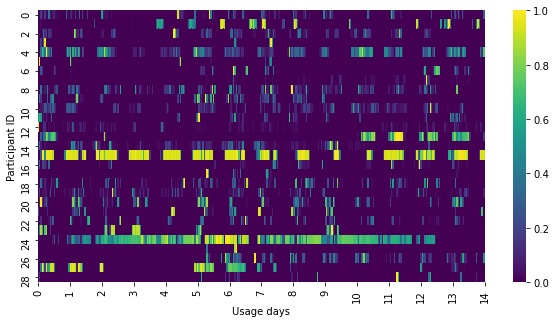

In [69]:
#create Heatmap for the first 2 weeks of each user

import seaborn as sns
forHeatmap = copy.deepcopy(hourlyUsedPerUser)

#normalize time to 2 weeks
forHeatmap2Weeks = []
for idx,participant in enumerate(forHeatmap):
    forHeatmap2Weeks += [[]]
    for i in range(336):
        forHeatmap2Weeks[idx] += [0]
    #Use the active 2 weeks
    if(all(i < 1 for i in forHeatmap[idx][:167])):
        for i in range(336):
            forHeatmap2Weeks[idx][i] = forHeatmap[idx][i+167]
    elif(all(i==0 for i in forHeatmap[:120])):
        for i in range(336):
            forHeatmap2Weeks[idx][i] = forHeatmap[idx][i+120]
    else:
        for i in range(336):
            forHeatmap2Weeks[idx][i] = forHeatmap[idx][i]

#normalize
for i in forHeatmap2Weeks:
    maxEntry = max(i)
    for idx, hour in enumerate(i):
        i[idx] = hour / maxEntry

forHeatmap2Weeks = np.array(forHeatmap2Weeks)

fig = plt.figure()
sns.heatmap(forHeatmap2Weeks, cmap="viridis")
plt.xlabel("Usage days")
plt.ylabel("Participant ID")
plt.xticks([0,24,48,72,96,120,144,168,192,216,240,264,288,312,336], [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
fig.set_size_inches(10, 5)
plt.savefig(destFolder + "hourlyUses.pdf")

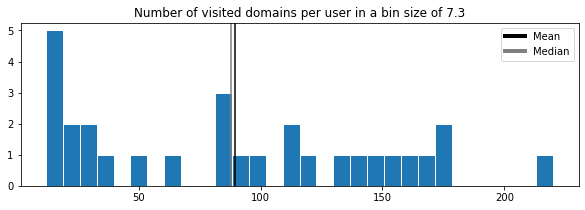

In [66]:
#create graphic of known pages
from matplotlib.lines import Line2D
fig = plt.figure()
plt.hist(numberKnownPagesPerUser, edgecolor='white',bins = 30)
plt.axvline(statistics.median(numberKnownPagesPerUser), color = 'grey')
plt.axvline(statistics.mean(numberKnownPagesPerUser), color = 'k')
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='grey', lw=4)]
plt.legend(custom_lines, ['Mean', 'Median'])
binSize = round(max(numberKnownPagesPerUser) / 30,1)
plt.title("Number of visited domains per user in a bin size of " + str(binSize))
fig.set_size_inches(10, 3)
plt.savefig(destFolder + "knownDomains.pdf")

total logins: 1900; smaller 120s: 1059; smaller 20s: 683


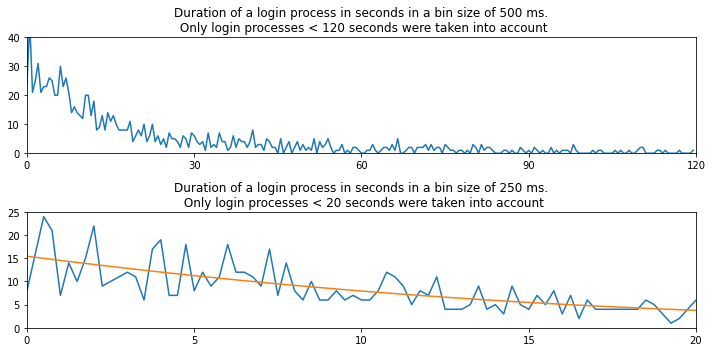

In [65]:
#create graphic of durations of logins

#remove duplicates from array
forDurationLogins = copy.deepcopy(actionsAfterIconSafeInsertion)
durations = []
for idx, participant in enumerate(forDurationLogins):
    for idy, icon in enumerate(participant):
        for action in icon:
            if(action[1] == "icon"):
                del forDurationLogins[idx][idy]
                break
for idx, participant in enumerate(forDurationLogins):
    for idy, icon in enumerate(participant):
        if(icon[-1][1] == 'PDSiteFunctionalityInitiatedSame' or icon[-1][1] == 'windowUnloadSame'):
            durations += [icon[-1][0]]


durationArray = []
print("total logins: " + str(len(durations)) + "; smaller 120s: " + str(((np.array(durations) <= 120000).sum())) + "; smaller 20s: " + str(((np.array(durations) <= 20000).sum())))

for i in range(240):
    durationArray += [0]
for duration in durations:
    if(duration < 120000):
        duration = math.floor(duration/500)
        durationArray[duration] += 1
fig, (ax1, ax2) = plt.subplots(2)
fig.set_size_inches(10, 5)
ax1.plot(durationArray)
plt.sca(ax1)
plt.xticks([0,60,120,180,240],[0,30,60,90,120])
ax1.axis([0,240,0,40])
ax1.set_title('Duration of a login process in seconds in a bin size of 500 ms.\n Only login processes < 120 seconds were taken into account')

#for first 20 seconds
indexArray = []
durationArray = []
for i in range(960):
    durationArray += [0]
for i in range(960):
    durationArray[i] = 0
    indexArray += [i]
for duration in durations:
    if(duration < 80000):
        duration = math.floor(duration/250)
        durationArray[duration] += 1
z = np.polyfit(indexArray, durationArray, 10)
p = np.poly1d(z)
ax2.plot(durationArray)
ax2.plot(indexArray, p(indexArray))
ax2.axis([0,80,0,25])
plt.sca(ax2)
plt.xticks([0,20,40,60,80],[0,5,10,15,20])
ax2.set_title('Duration of a login process in seconds in a bin size of 250 ms.\n Only login processes < 20 seconds were taken into account')

plt.tight_layout()
plt.savefig(destFolder + "LoginTimes.pdf")


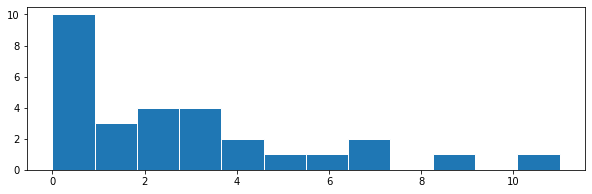

In [24]:
#Verteilung der Hoveranzahlen
fig = plt.figure()
plt.hist(numberHoversPerUser, edgecolor='white', bins=12)
fig.set_size_inches(10, 3)
plt.show()

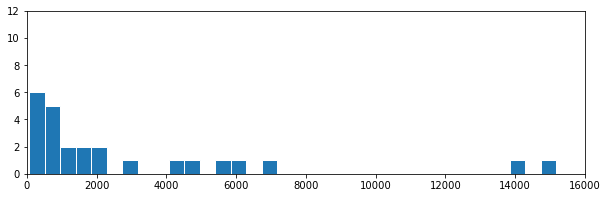

In [47]:
#Verteilung der Webseitenvisits
fig = plt.figure()
plt.hist(numberPDInitiatesPerUser, edgecolor='white', bins=200)
plt.axis([0,16000,0,12])
fig.set_size_inches(10, 3)
plt.savefig(destFolder + "numberInits.pdf")


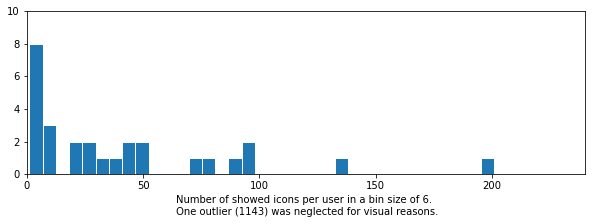

In [26]:
#Verteilung der Iconzahlen
fig = plt.figure()
plt.hist(numberIconsShowedPerUser, edgecolor='white', bins=200)
plt.axis([0,240,0,10])
plt.xlabel('Number of showed icons per user in a bin size of 6. \n One outlier (1143) was neglected for visual reasons.')
fig.set_size_inches(10, 3)
plt.show()

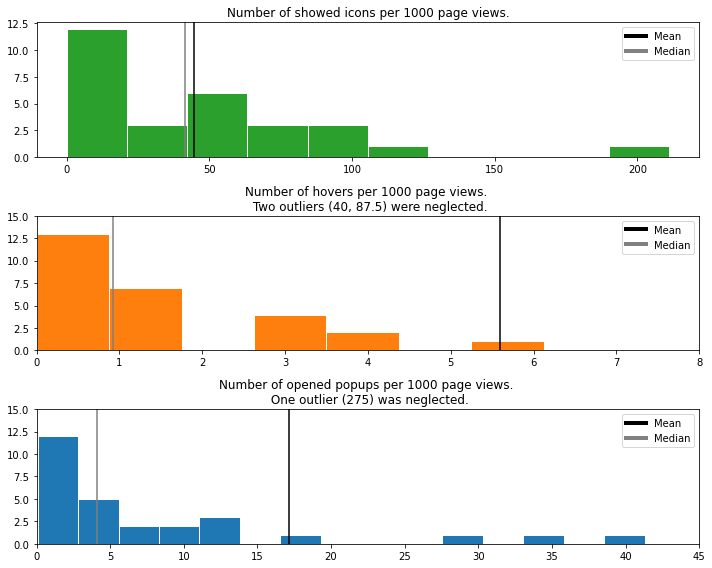

In [32]:
#Verteilung der Icons, Hovers und Popupzahlen pro Inits (Done in Excel)
from matplotlib.lines import Line2D

forPopupsRelative = copy.deepcopy(numberPopupsPerUser)
for idx, person in enumerate(forPopupsRelative):
    forPopupsRelative[idx] = person / numberPDInitiatesPerUser[idx] * 1000

forIconsRelative = copy.deepcopy(numberIconsShowedPerUser)
for idx, person in enumerate(forIconsRelative):
    forIconsRelative[idx] = person / numberPDInitiatesPerUser[idx] * 1000

forHoversRelative = copy.deepcopy(numberHoversPerUser)
for idx, person in enumerate(forHoversRelative):
    forHoversRelative[idx] = person / numberPDInitiatesPerUser[idx] * 1000

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(10, 8)

ax1.hist(forIconsRelative, edgecolor='white', color='tab:green')
ax1.axvline(statistics.median(forIconsRelative), color = 'grey')
ax1.axvline(statistics.mean(forIconsRelative), color = 'k')
#ax1.axis([0,220,0,15])
ax1.set_title('Number of showed icons per 1000 page views.')

ax2.hist(forHoversRelative, edgecolor="white", bins = 100, color='tab:orange')
ax2.axvline(statistics.median(forHoversRelative), color = 'grey')
ax2.axvline(statistics.mean(forHoversRelative), color = 'k')
ax2.axis([0,8,0,15])
ax2.set_title('Number of hovers per 1000 page views. \n Two outliers (40, 87.5) were neglected.')

ax3.hist(forPopupsRelative, edgecolor='white', bins = 100)
ax3.axvline(statistics.median(forPopupsRelative), color = 'grey')
ax3.axvline(statistics.mean(forPopupsRelative), color = 'k')
ax3.axis([0,45,0,15])
ax3.set_title('Number of opened popups per 1000 page views. \n One outlier (275) was neglected.')


#plt.xlabel('Number of opened popups (above) and appended icons (beelow) per 1000 page views')
#ax3.xlabel('Number of appended icons per 1000 page views')
fig.tight_layout()
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='grey', lw=4)]

ax1.legend(custom_lines, ['Mean', 'Median'])#
ax2.legend(custom_lines, ['Mean', 'Median'])
ax3.legend(custom_lines, ['Mean', 'Median'])

plt.savefig(destFolder + "IconsHoversPopups.pdf")

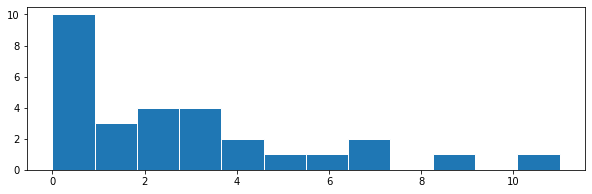

In [28]:
#Verteilung der Hovers
fig = plt.figure()
plt.hist(numberHoversPerUser, edgecolor='white', bins=12)
fig.set_size_inches(10, 3)
plt.show()

<Figure size 540x252 with 0 Axes>

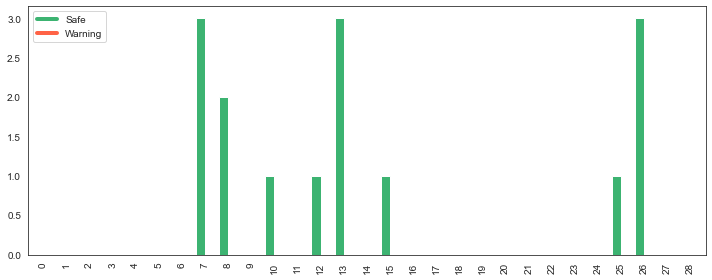

In [128]:
#Wann wurde VTT aufgerufen

import pandas as pd
from matplotlib.lines import Line2D

def whatWasDoneBeforeVTT(activityArray):
    numberSafeWebsites = 0
    numberUnknownWebsites = 0
    numberWarningWebsites = 0
    forbiddenActions = ["notKnown", "www.virustotal.com"]
    for idx,entry in enumerate(activityArray):
        if(entry[2] == "PDSiteFunctionalityInitiated" and entry[6] == "www.virustotal.com"):
            for i in range(min (100, len(activityArray) - idx)):
                if(not (activityArray[idx - (i + 1)][6] in forbiddenActions)):
                    reason = activityArray[idx - (i + 1)][3]
                    source = activityArray[idx - (i + 1)][4]
                    if(reason == "safe" and not(source == "attentionTest")): numberSafeWebsites += 1
                    elif(reason == "warning" or source == "attentionTest"): numberWarningWebsites += 1
                    else: print(reason)
                    break
    return [numberSafeWebsites, numberUnknownWebsites, numberWarningWebsites]

doneBeforeVTTSafe = []
doneBeforeVTTWarning = []
i = 0
for activityArray in activityArrays:
    i += 1
    whatWasDoneBefore = whatWasDoneBeforeVTT(activityArray)
    doneBeforeVTTSafe += [whatWasDoneBefore[0]]
    doneBeforeVTTWarning += [whatWasDoneBefore[2]]

dataForPlot = pd.DataFrame({
    "safe": doneBeforeVTTSafe,
    "warning": doneBeforeVTTWarning
})
color_dict = {'safe': '#3CB371', 'warning': '#FF6346'}

fig = plt.figure()

ax1 = dataForPlot[['safe','warning']].plot(kind='bar', width = 0.8, figsize=(10,4), color=[color_dict.get(x, '#333333') for x in dataForPlot.columns])
custom_lines = [Line2D([0], [0], color='#3CB371', lw=4),
                Line2D([0], [0], color='#FF6346', lw=4)]
plt.xlabel('')
sns.set_style("white")

ax1.legend(custom_lines, ['Safe', 'Warning'])
plt.savefig(destFolder + "pagesBeforeVTT.pdf")


In [ ]:
print("This is the second last cell")

In [ ]:
print("This is the last cell")